**TODO**



1.   Combine all new images into a single folder - Piyush
2.   Use Model to classify new images as with or without mask - Jaspreet 
3.   Use pretrained model to get a good model which is stable unlike cuurent one
4.   Use Face Recognition to preprocess all the images
5.   Retrain the model

Everything looks great vgg19, resnet50 are working as well. If we can somehow restrict the dataset to just images of faces, then we can have a very strong model and use it it face detection to make a final video.



In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.layers import Activation, Dropout
from keras.optimizers import Adam, RMSprop
from keras.applications import VGG19,VGG16,ResNet50,ResNet50V2,ResNet152V2
from keras import backend as K
from keras.callbacks import LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets  as tfds
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model, to_categorical

from PIL import Image as pil_image
from matplotlib import pyplot as plt
import time


In [2]:
# Download dataset from github

# With Mask
!npx degit pdhimate/machinelearning/face_mask/dataset/with_mask/#32a39624c9e99f099611e74b1735245caa0f664c -f with_mask
#!npx degit pdhimate/machinelearning/face_mask/dataset/raw/RMFD_part_3/single2-0#c845ed6adfc3cc6ff46d00fb7f4826c34c759f0a -f with_mask

# Without Mask
!npx degit pdhimate/machinelearning/face_mask/dataset/without_mask/#32a39624c9e99f099611e74b1735245caa0f664c -f without_mask


npx: installed 1 in 0.888s
> destination directory is not empty. Using --force, continuing
> cloned pdhimate/machinelearning#32a39624c9e99f099611e74b1735245caa0f664c to with_mask
npx: installed 1 in 2.032s
> destination directory is not empty. Using --force, continuing
> cloned pdhimate/machinelearning#32a39624c9e99f099611e74b1735245caa0f664c to without_mask


In [3]:
# detects faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_alt2.xml')

In [4]:
# Init variables and funcs
WITH_MASK_DIR = '/content/with_mask'
WITHOUT_MASK_DIR =  '/content/without_mask'
img_height, img_width = 64, 64

def preprocess_dataset(dir, labels):
  for file in tqdm(os.listdir(dir)):
    path = os.path.join(dir, file)
    img = cv2.imread(path)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert to grayscale
    faces = face_cascade.detectMultiScale(img, 1.1, 4)
    # If face detected then crop the face part
    if len(faces) > 0:
      for (x,y,w,h) in faces:
            #print(faces)
            face = img[int(y):int(y+h), int(x):int(x+w)]
            face = cv2.resize(face, (img_width, img_height))
            face = face/255
            dataset.append([np.array(face), np.array(labels)])

    else:
      img = cv2.resize(img, (img_width, img_height))
      img = img/255
      dataset.append([np.array(img), np.array(labels)])

def plot_accuracy_loss(train_ac, val_ac, train_loss, val_loss):
  # Plot Epoch vs Accuracy metric values
  plt.plot(train_ac, label='training accuracy')
  plt.plot(val_ac, label = 'validation accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

  # Plot Epoch vs loss values
  plt.plot(train_loss, label = 'training loss')
  plt.plot(val_loss, label = 'validation loss')
  plt.title('Model loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# helper functions to create the pipeline and augment images
def image_preprocessor(image, label):
  #image = tf.image.convert_image_dtype(image, tf.float32)  
  #image = tf.image.resize(image, [img_width,img_width]) 
  # image = tf.reshape(image, (28,28,1)) # 28,28 to 28,28,1 (single channel)
  #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # convert to grayscale
  return image, label

def image_augmenter(image, label):
  image = tf.image.random_flip_up_down(image)  # vertical flip
  image = tf.image.random_flip_left_right(image)  # horizontal flip
  return image, label

def read_all_images(dir, labels, dataset):
  for file in tqdm(os.listdir(dir)):
    path = os.path.join(dir, file)
    img = cv2.imread(path)
    img = cv2.resize(img, (img_width, img_height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dataset.append((np.array(img), np.array(labels)))

# Model fine tuner for pipelines as inputs
def train_tune_model_piped(model_creators, # parameterless func that creates a model
                     train_data_pipe, val_data_pipe, test_data_pipe, # dataset pipelines
                     learning_rates, epochs, optimizers, loss_funcs,  # hyper-parameters
                     batch_size, callbacks, steps = 100, verbose=0):
  results = []
  for model_creator in model_creators:  
    for epoch in epochs:
      for opt in optimizers:
        for lr in learning_rates:
          for lf in loss_funcs:
            print("############## Running for following parameters ###############")
            model_name = str(model_creator.__name__)
            print("Model: ", model_name, "Epochs: ", epoch,", Optimizer: ", opt, ", Learning rate: ", lr, ", Loss Function: ", lf)
            model = model_creator()
            model.compile( loss= lf, optimizer= opt, metrics=['accuracy'])
            K.set_value(model.optimizer.learning_rate, lr)
            start_time = time.time()
            with tf.device('/device:GPU:0'):
              hist = model.fit(train_data_pipe ,epochs = epoch,
                              steps_per_epoch = steps,#(len(train_data_pipe)/batch_size
                              #batch_size = batch_size, # todo uncomment this before creating the HTML output file
                              validation_steps = steps,
                              validation_data = val_data_pipe,
                              callbacks = callbacks,verbose=verbose)
            execution_sec = (time.time() - start_time)
            result = model.evaluate(test_data_pipe)
            results.append({ 'Model': model_name, 'Epochs': epoch,'Optimizer': opt,'Learning rate': lr,'Loss Function': lf,
                        'Test Accuracy': result[1],'Train Time (sec)':execution_sec, 'History': hist,'Model': model })
            print("Run complete. Test accuracy is: ", result[1])
            print("")
  # Sort results by Test Accuracy descending.
  results = pd.DataFrame(results).sort_values('Test Accuracy', ascending = False)
  best_model = results.iloc[[0]]['Model'].values[0] # used for predictions if needed
  best_model_history = results.iloc[[0]]['History'].values[0] # used for plotting
  results = results.iloc[:,:-2] # we ignore last 2 columns which model and history.  
  return best_model, best_model_history, results              


# Model definitions
def cnn_model():
  model = Sequential()

  model.add(Conv2D(32, (3,3), input_shape=train_x.shape[1:], activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Conv2D(128, (3,3), activation='relu'))
  model.add(MaxPooling2D((2,2), strides=(1,1), padding='same'))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  return model

def dense_model():
  model = Sequential()

  model.add(layers.BatchNormalization(input_shape=train_x.shape[1:]))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))

  return model

def resnet_model():
  model = ResNet50(weights=None, # we dont use pretrained weights
            include_top=True,
            input_shape=train_x.shape[1:], # size of our input
            classes=2) 
  return model


def vgg_model():
  model = VGG19(weights=None, # we dont use pretrained weights
            include_top=True,
            input_shape=train_x.shape[1:], # size of our input
            classes=2) 
  return model


In [5]:
# read all images with labels from dir/files
# Stores the entire dataset
dataset = []
read_all_images(WITH_MASK_DIR, [1,0], dataset)
read_all_images(WITHOUT_MASK_DIR, [0,1], dataset)

100%|██████████| 1850/1850 [00:02<00:00, 904.48it/s]


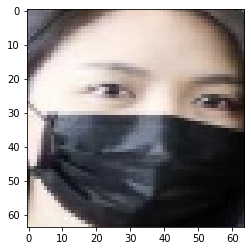

In [6]:
# Display image
#pil_image.fromarray(dataset[0][0]).convert('RGB')
plt.imshow(dataset[71][0],cmap='gray')

In [7]:
# Slice the Data adn Labels
data = np.array([i[0] for i in dataset])#.reshape(-1, img_height, img_width, 3)
labels = np.array([i[1] for i in dataset])
print()
print("Data Shape: ", data.shape)
print("Label shape", labels.shape)

# Stratified split to Train, Test and Val
train_x, test_x, train_y, test_y = train_test_split(data,labels, test_size=0.2, random_state=42, stratify=labels)
train_x, val_x, train_y, val_y = train_test_split(train_x,train_y, test_size=0.25, random_state=42, stratify=train_y)
print()
print("Train dataset", train_x.shape, train_y.shape)
print("Test dataset",test_x.shape, test_y.shape)
print("Val dataset", val_x.shape, val_y.shape)

# Create pipelines
batch_size = 128
train_pipe = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_pipe = (train_pipe
              .map(image_preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
              .map(image_augmenter, num_parallel_calls=tf.data.experimental.AUTOTUNE)
              .batch(batch_size) # batch the data so that we do not run out of RAM.
              .cache()
              .repeat() # repeat so that fit() does not run out of data while running a step (depending on batch size)
              .prefetch(tf.data.experimental.AUTOTUNE)) # This was added to improve performance as checked in profiler
val_pipe = (tf.data.Dataset.from_tensor_slices((val_x, val_y))
              .map(image_preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
              .batch(batch_size).cache().repeat())
test_pipe = (tf.data.Dataset.from_tensor_slices((test_x, test_y))
              .map(image_preprocessor, num_parallel_calls=tf.data.experimental.AUTOTUNE)
              .batch(batch_size).cache())
print()
print("Pipelines created. Specs: ")
print("Train pipe: ", train_pipe.element_spec)
print("Test pipe: ", test_pipe.element_spec)
print("Validation pipe: ", val_pipe.element_spec)

# Set hyper parameters
model_creators = [ vgg_model, resnet_model, dense_model]
epochs = [10]  
optimizers = ['adam']
learning_rates = [0.0001]
loss_functions = [ 'binary_crossentropy']
steps = 50#len(train_x)/batch_size
callbacks =[]#[ReduceLROnPlateau(monitor='val_accuracy',patience=2,verbose=1,factor=0.5, min_lr=0.00001)]
# EarlyStopping( monitor='val_loss', min_delta = 0, # any change less than 0 counts as no improvement
#     patience = 7, # wait until these many epochs with no imporvemnt then stop training
#     verbose = 2, mode='auto')]

# Train model
print()
print("Training the model")
best_model, best_accuracy_result, results_df = train_tune_model_piped(
                model_creators, # parameterless functions that create a model
                train_pipe, val_pipe, test_pipe, # data pipes
                learning_rates, epochs, optimizers, loss_functions,  # hyper-parameters
                batch_size, callbacks, steps, 1)



Data Shape:  (3689, 64, 64, 3)
Label shape (3689, 2)

Train dataset (2213, 64, 64, 3) (2213, 2)
Test dataset (738, 64, 64, 3) (738, 2)
Val dataset (738, 64, 64, 3) (738, 2)

Pipelines created. Specs: 
Train pipe:  (TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.int64, name=None))
Test pipe:  (TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.int64, name=None))
Validation pipe:  (TensorSpec(shape=(None, 64, 64, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None, 2), dtype=tf.int64, name=None))

Training the model
############## Running for following parameters ###############
Model:  vgg_model Epochs:  10 , Optimizer:  adam , Learning rate:  0.0001 , Loss Function:  binary_crossentropy
Epoch 1/10
50/50 [==============================] - 12s 247ms/step - loss: 0.5850 - accuracy: 0.6893 - val_loss: 0.2769 - val_accuracy: 0.9002
Epoch 2/10
50/50 [==============================] - 1

In [8]:
print("Below are the results of the tuning runs sorted by accuracy in descending order. ")         
results_df

Below are the results of the tuning runs sorted by accuracy in descending order. 


,Model,Epochs,Optimizer,Learning rate,Loss Function,Test Accuracy
0,<tensorflow.python.keras.engine.functional.Fun...,10,adam,0.0001,binary_crossentropy,0.960705
2,<tensorflow.python.keras.engine.sequential.Seq...,10,adam,0.0001,binary_crossentropy,0.899729
1,<tensorflow.python.keras.engine.functional.Fun...,10,adam,0.0001,binary_crossentropy,0.857724


In [9]:
print("Best model name     : ", results_df.iloc[0][0].name)
print("Next Best model name: ", results_df.iloc[1][0].name)
print("Next Best model name: ", results_df.iloc[2][0].name)

Best model name     :  vgg19
Next Best model name:  sequential
Next Best model name:  resnet50


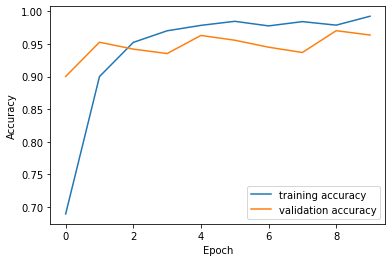

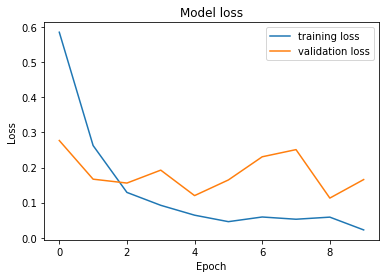

In [10]:
# plot performance
plot_accuracy_loss(best_accuracy_result.history['accuracy'],
                   best_accuracy_result.history['val_accuracy'],
                   best_accuracy_result.history['loss'], 
                   best_accuracy_result.history['val_loss'])


In [11]:
# Save trained model for reuse
best_model.save("model.h5")

In [12]:
# Another way to save model (gives ~4 times smaller files)
model_json = best_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
best_model.save_weights("model_weights.h5")

In [17]:
# Size in MB
print(os.path.getsize("/content/model_weights.h5")/1000000)
print(os.path.getsize("/content/model.h5")/1000000)
print(os.path.getsize("/content/model.json")/1000000)

180.893608
542.658824
0.013572
